In [1]:
from pathlib import Path
import tifffile
from matplotlib import pyplot as plt
from skimage import morphology, filters, measure, feature
import numpy as np
import pandas as pd
import math
import miguel_tools as mt
import seaborn as sns
import math
from collections import defaultdict
from scipy.spatial import distance
import napari
from skimage import data
from scipy.ndimage import gaussian_laplace

In [38]:
# import napari
# from skimage import data

# a = data.astronaut()[:,:,0]
# b = np.concatenate([a, a, a, a, a, a,a])
# c = np.concatenate([b, b, b, b, b, b,b], axis=1)


# with napari.gui_qt(): # Here just select manually two squares which cover part of the borders of the image
#         viewer = napari.Viewer()
#         viewer.add_image(c)

# shapes = viewer.layers['Shapes'].to_labels()
# print(c.shape, shapes.shape)
# plt.imshow(shapes)
# plt.show()
# plt.imshow(c)

# # With this surprisingly works
# with napari.gui_qt():
#         viewer = napari.Viewer()
#         viewer.add_image(c)
#         viewer.add_labels(shapes)

In [39]:
# imRAW = tifffile.imread(str(list(folder.parent.glob("*tif"))[-1]))

In [40]:
# import napari
# with napari.gui_qt():
#         viewer = napari.Viewer()
#         viewer.add_image(imRAW[imRAW.shape[0]-1][:,:, 0])

In [41]:
# imRAW.shape

In [42]:
# shapes = viewer.layers['Shapes'].to_labels()
# # mt.napariView(imRAW[imRAW.shape[0]-1], label_im=shapes)
# plt.imshow(shapes)
# shapes.shape

In [3]:
folder = Path(r"D:\TEMP_PICTURES\Lichun\Training")
files = list(folder.glob("*tif"))
ims = [tifffile.imread(str(i)) for i in files]
mt.print_pretty_list(files)

0 D:\TEMP_PICTURES\Lichun\Training\TRIAL-1.tif
1 D:\TEMP_PICTURES\Lichun\Training\TRIAL-10.tif
2 D:\TEMP_PICTURES\Lichun\Training\TRIAL-2.tif
3 D:\TEMP_PICTURES\Lichun\Training\TRIAL-3.tif
4 D:\TEMP_PICTURES\Lichun\Training\TRIAL-4.tif
5 D:\TEMP_PICTURES\Lichun\Training\TRIAL-5.tif
6 D:\TEMP_PICTURES\Lichun\Training\TRIAL-6.tif
7 D:\TEMP_PICTURES\Lichun\Training\TRIAL-7.tif
8 D:\TEMP_PICTURES\Lichun\Training\TRIAL-8.tif
9 D:\TEMP_PICTURES\Lichun\Training\TRIAL-9.tif


In [4]:
chosen = 0
im = ims[chosen]
r, g, b = [im[:,:,:, i] for i in range(im.shape[-1])]
print(r.shape, g.shape, b.shape)

(119, 704, 360) (119, 704, 360) (119, 704, 360)


In [108]:
def extract_baby_plant(im_slice):
    mask_otsu = im_slice < filters.threshold_otsu(im_slice)
    labelIM = morphology.label(mask_otsu)
    props = measure.regionprops(label_image=labelIM, intensity_image=im_slice)

    features = []

    for feat in ['label', 'area', 'perimeter', 'bbox']:
        serie = pd.Series([i[feat] for i in props], name=feat)
        features.append(serie)

    DF = pd.DataFrame(features).T

    biggest_label = DF.sort_values(['area'], ascending=False).reset_index().loc[0]['label']
    bbox = DF.sort_values(['area'], ascending=False).reset_index().loc[0]['bbox']
    baby_mask = np.where(labelIM == biggest_label, 1, 0)
    
    return baby_mask, bbox


def hightlight_babyplant(im):
    b=filters.sobel(image)
    #     bgaus = filters.gaussian(b, sigma=1)
    #     c =np.stack([filters.sobel_h(i) for i in bgaus], axis=0)

    #     mask_otsu = b < filters.threshold_otsu(b)
    return b

In [113]:
baby_plant_highlighted = hightlight_babyplant(r)

In [106]:
mt.napariView(b)

In [46]:
# for i in r:
#     a = extract_baby_plant(im_slice=im_slice)
#     plt.imshow(a);
#     plt.show()

In [47]:
# mask_otsu = im_slice < filters.threshold_otsu(im_slice)
# mask_sobel = filters.sobel(im_slice)
# mask_canny = feature.canny(im_slice, sigma=1.6)
# mask_gaussian = filters.gaussian(im_slice, sigma=1.5)

In [48]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# images = [mask_otsu, mask_sobel, mask_canny, mask_gaussian]
# for i in range(len(ax)):
#     ax[i].imshow(images[i])

In [49]:
# tifffile.imshow(im_slice)

In [50]:
# mt.napariView([r, result])

In [110]:
med = np.mean(r, axis=0)
med_sharp = filters.unsharp_mask(med, radius=8, amount=40)

a, bbox = extract_baby_plant(med_sharp)
a = morphology.remove_small_holes(a.astype(bool), area_threshold=300)
mask = np.where(a == True, 50, 1)
result = mask * r # Cleaned background
result_cut = result[:, bbox[0]:bbox[2], bbox[1]:bbox[3]]
max_result_cut = np.max(result_cut, axis=2)

In [112]:
mt.napariView(result)

In [54]:
#### Heatmap
# sns.set(font_scale=1.4)
# fig = plt.figure(figsize=(30, 40))
# ax = sns.heatmap(max_result_cut, yticklabels=timepoints)#, linecolor='black', linewidths=0.01)
# xlabels = ['{} mm'.format(x*2) for x in ax.get_xticks()]
# ax.set_xticklabels(xlabels)
# plt.suptitle("baby plant 1", y=0.9)
# plt.show()

In [55]:
# # texts = [t.get_text()  for t in ax.get_xticklabels()]
# # new = [float(i)*pixel_size for i in texts]

# shapeaxis2 = np.max(result_cut, axis=2).shape[-1]
# step = math.ceil(shapeaxis2/28)

# xtickold = list(range(0, shapeaxis2, step))
# # xtickold

# pixel_size = 2 # mm
# xticks_mm = ["{} mm".format(i*pixel_size) for i in xtickold]

In [118]:
timepoints = [i.stem for i in sorted(list(Path('D:/TEMP_PICTURES/Lichun/Trial_raw').glob("*")))]

In [57]:
%matplotlib inline

plt.figure(figsize=(20,20))
plt.imshow(max_result_cut)
xaxis, yaxis = max_result_cut.shape[-1], max_result_cut.shape[-2]
xticks = np.linspace(1, xaxis, 16)
pixel_size = 2 # mm
xlabels = np.array([int(i)*pixel_size for i in xticks])
plt.xticks(ticks=xticks, labels=xlabels, rotation=90, size=12);
plt.xlabel("mm", size=15)

yticks = np.linspace(1, yaxis, 16)
ylabels = [timepoints[i] for i in range(len(yticks))]
plt.yticks(ticks=yticks, labels=ylabels, rotation=0, size=12);
plt.ylabel("time (s)", size=15)
plt.title("{}".format(files[chosen].stem))

plt.grid(color='black')
plt.savefig(folder / "{}_lateral_view.png".format(files[chosen].stem), dpi=300,bbox_inches = 'tight')

In [65]:
mt.napariView(result_cut)

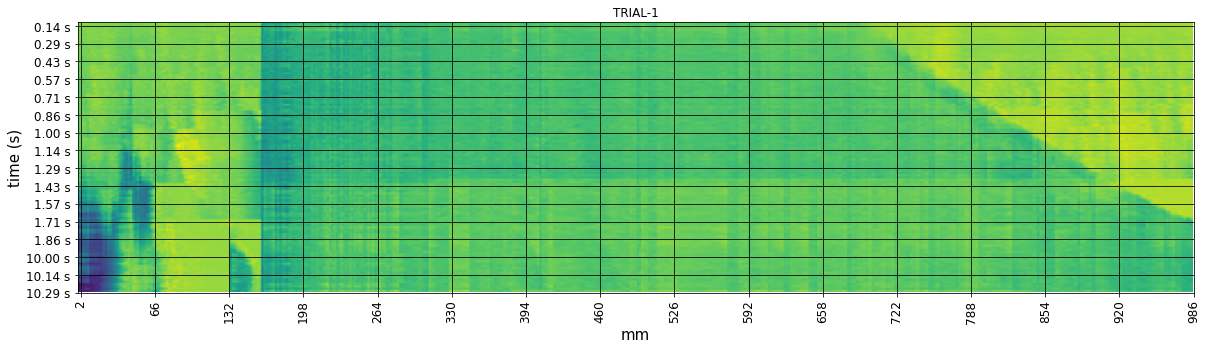

In [58]:
# max_0 = np.rot90(np.max(result_cut, axis=0))
# # max_0 = np.max(result_cut, axis=0)
# plt.imshow(max_0)

In [59]:
# max_cut_rotated = np.rot90(result_cut, axes=(1, 2))
# print(max_cut_rotated.shape)
# fig = plt.figure()
# for ix, i in enumerate(max_cut_rotated):
#     plt.imshow(i)

# Calculating lateral movement

In [114]:
import napari
with napari.gui_qt():
        viewer = napari.Viewer()
        viewer.add_image(np.rot90(baby_plant_highlighted, axes=(1,2)))
        viewer.add_points(name='path', face_color='green', opacity=0.9, symbol='square', size=5, n_dimensional=False)
        viewer.layers['path'].mode = 'add'

DATA = pd.DataFrame(viewer.layers['path'].__dict__['_data'], columns=['timepoint', 'y', 'x'])

In [115]:
DATA.insert(loc=0, column='cap', value=DATA.index)
DATA

,cap,timepoint,y,x
0,0,0.0,185.668622,156.476466
1,1,0.0,191.362739,178.303917
2,2,0.0,199.903915,203.927445
3,3,0.0,198.005876,226.703915
4,4,0.0,198.480386,251.852934
5,5,0.0,198.480386,272.731364
6,6,0.0,199.903915,295.033324
7,7,0.0,196.582347,319.233324
8,8,0.0,197.056857,341.535284
9,9,0.0,198.480386,371.903910


In [116]:
angle_of_line = lambda point1, point2: math.degrees(math.atan2(point2['y']-point1['y'], point2['x']-point1['x'])) 
middle_point = lambda point1, point2: ((point1['y']+(point2['y'] - point1['y'])/2), \
                                            (point1['x']+(point2['x'] - point1['x'])/2))
# angle_of_line(DATA.loc[1], DATA.loc[2])

middles = defaultdict(list)
for i in DATA.index:
    try:
        middle = middle_point(DATA.loc[i], DATA.loc[i+1])
        middles['caps'].append("{}-{}".format(int(DATA.loc[i]['cap']), int(DATA.loc[i+1]['cap'])))
        middles['y'].append(middle[0])
        middles['x'].append(middle[1])
        
        degree = angle_of_line(DATA.loc[i], DATA.loc[i+1])
        middles['degree'].append(degree)
    except:
        pass

DFresults = pd.DataFrame(middles)
DFresults

,caps,y,x,degree
0,0-1,188.515681,167.390191,14.620874
1,1-2,195.633327,191.115681,18.434949
2,2-3,198.954896,215.315680,-4.763642
3,3-4,198.243131,239.278424,1.080924
4,4-5,198.480386,262.292149,0.000000
5,5-6,199.192151,283.882344,3.652223
6,6-7,198.243131,307.133324,-7.815294
7,7-8,196.819602,330.384304,1.218875
8,8-9,197.768621,356.719597,2.683775
9,9-10,200.141170,389.935282,5.262395


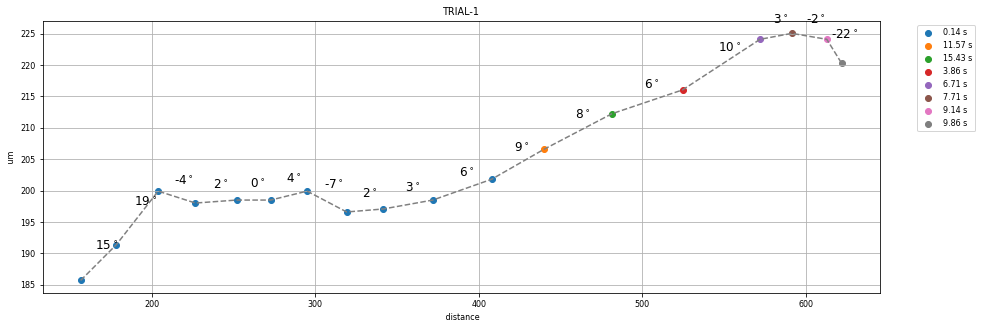

In [119]:
fig = plt.figure(figsize=(15,5))
drift = 0
last_position = 0
for name, group in DATA.groupby(['timepoint']):
    plt.scatter(group.x, group.y, label=timepoints[int(name)])
#     for ix, row in group.iterrows():
#         dst = distance.euclidean(last_position, (row.x, row.y))
#         if dst < 5:
#         plt.text(row.x, row.y+drift, s=timepoints[int(row.timepoint)], fontdict={'size':9})
#         else:
#             plt.text(row.x, row.y, s=timepoints[int(row.timepoint)], fontdict={'size':9})
            
#         last_position = (row.x, row.y)
#         drift += 1.4
        
plt.plot(DATA.x, DATA.y, color='grey', linestyle='--')
for ix, dg in enumerate(DFresults['degree']):
    plt.text(x=DFresults.loc[ix]['x']-2,y=DFresults.loc[ix]['y']+2, s="{}$^\circ$".format(math.ceil(dg)), size=12)
    
# plt.ylim(DATA.y.max()+5, DATA.y.min()-5)
# # plt.xlim(100, 200)
plt.ylabel(" um ")
plt.xlabel(" distance")
# plt.xticks(ticks=np.linspace(100, 200, 10), labels=[int(i) for i in np.linspace(100, 200, 10)], rotation=45);
plt.title("{}".format(files[chosen].stem))
plt.grid(axis='both')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");
plt.savefig(folder / "{}_lateral_view_degrees.png".format(files[chosen].stem), dpi=300, bbox_inches = 'tight')

In [120]:
mt.writting_excel(DF=[DATA, DFresults], 
                  pathname=folder / "{}_data.xslx".format(files[chosen].stem), 
                  sheet_name=['raw_data', 'degrees'])